# Computer Vision Lecture - Exercise 5 Part 1 - Implicit Models

In this exercise, you will gain hands-on experience regarding 3D representations of objects. More specifically, we will train our own simple Occupancy Network to represent a 3D shape implicitly and learn how to extract a mesh from such an implicit representation!

This notebook guides you through the relevant steps. When you see helper functions, you don't need to do anything - they are already implemented. The functions you need to implement are indicated as Exercise Function. Sometimes, you can find Hints - these are written upside-down so you can first try to find the solution without reading them.

Good luck and lot's of fun!

## Preliminaries
Let's first install dependencies, import libaries and define the input and output directories.

In [1]:
print("hello")

hello


In [1]:

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import numpy as np
import torch
import torch.nn as nn
# from tqdm import tqdm
from livelossplot import PlotLosses
from skimage.measure import marching_cubes    # Lewiner et al. algorithm is faster, resolves ambiguities, and guarantees topologically correct results
%matplotlib inline
import matplotlib.pyplot as plt

# set random seed for reproducability
np.random.seed(42)

data_dir = 'data'
out_dir = 'output'

for d in [data_dir, out_dir]:
  os.makedirs(d, exist_ok=True)

Next, we need to import our training data, i.e. the 3D object that we want to represent. If you use Google Colab, drag the file `code/data/points.npz` from the exercise folder in `data`.

The file contains 100k sampling points together with their occupancy value. The occupancy value indicates if the point belongs to the object (`occupancy=1`) or to free space (`occupancy=0`). \\
We now define some helper functions to load and visualize the data.

In [3]:
###########################
##### Helper Function #####
###########################
def load_data(file_path):
  ''' Load points and occupancy values from file.

  Args:
  file_path (string): path to file
  '''
  data_dict = np.load(file_path)
  points = data_dict['points']
  occupancies = data_dict['occupancies']

  # Unpack data format of occupancies
  occupancies = np.unpackbits(occupancies)[:points.shape[0]]
  occupancies = occupancies.astype(np.float32)

  # Align z-axis with top of object
  points = np.stack([points[:, 0], -points[:, 2], points[:, 1]], 1)

  return points, occupancies

In [4]:
###########################
##### Helper Function #####
###########################
def visualize_occupancy(points, occupancies, n=50000):
  ''' Visualize points and occupancy values.

  Args:
  points (torch.Tensor or np.ndarray): 3D coordinates of the points
  occupancies (torch.Tensor or np.ndarray): occupancy values for the points
  n (int): maximum number of points to visualize
  '''
  # if needed convert torch.tensor to np.ndarray
  if isinstance(points, torch.Tensor):
    points = points.detach().cpu().numpy()
  if isinstance(occupancies, torch.Tensor):
    occupancies = occupancies.detach().cpu().numpy()

  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')

  n = min(len(points), n)

  # visualize a random subset of n points
  idcs = np.random.randint(0, len(points), n)
  points = points[idcs]
  occupancies = occupancies[idcs]

  # define colors
  red = np.array([1,0,0,0.5]).reshape(1, 4).repeat(n,0)     # plot occupied points in red with alpha=0.5
  blue = np.array([0,0,1,0.01]).reshape(1, 4).repeat(n,0)   # plot free points in blue with alpha=0.01
  occ = occupancies.reshape(n, 1).repeat(4, 1)              # reshape to RGBA format to determine color

  color = np.where(occ == 1, red, blue)                     # occ=1 -> red, occ=0 -> blue
  
  # plot the points
  ax.scatter(*points.transpose(), color=color)

  # make it pretty
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  
  ax.set_xlim(-0.5, 0.5)
  ax.set_ylim(-0.5, 0.5)
  ax.set_zlim(-0.5, 0.5)

  plt.show()

Let's take a look at the data. 

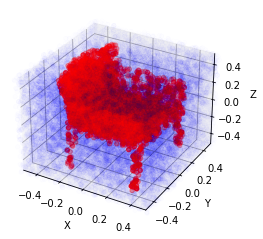

In [6]:
points, occupancies = load_data('data/points.npz')
visualize_occupancy(points, occupancies)

## Representing the Object Implicitly

Instead of using a set of explicit 3D points with occupancy values, our goal is now to encode the 3D shape *implicitly* by the decision boundary of a classifier. The classifier is parametrized as a simple fully connected neural network.

This brings us to our first exercise function. We first need to split the data into a training and a validation set.
Split the data randomly and use 80% for the training and 20% for the validation set.

*Hint 1*: `ɯopuɐɹ˙du` uᴉ suoᴉʇɔunɟ lnɟǝsn ǝɯos puᴉɟ ʇɥƃᴉɯ no⅄

In [7]:
from torch.utils import data
###########################
#### Exercise Function ####
###########################
def get_train_val_split(points, occupancies):
  ''' Split data into train and validation set.
  
  Args:
  points (torch.Tensor or np.ndarray): 3D coordinates of the points
  occupancies (torch.Tensor or np.ndarray): occupancy values for the points
  '''
  
  # Insert your code here
  train_len = int(0.8 * len(points))
  data = np.concatenate([points,occupancies.reshape(-1,1)],1)
  np.random.shuffle(data)
  train_data , val_data = np.split(data,[train_len])
  train_points , train_occs = train_data[:,:3] , train_data[:,3]
  val_points , val_occs = val_data[:,:3] , val_data[:,3]
  # this converts the points and labels from numpy.ndarray to a pytorch dataset
  train_set = torch.utils.data.TensorDataset(torch.from_numpy(train_points), torch.from_numpy(train_occs))
  val_set = torch.utils.data.TensorDataset(torch.from_numpy(val_points), torch.from_numpy(val_occs))
  return train_set, val_set

train_set, val_set = get_train_val_split(points, occupancies)

We will train our network with batches of data, so let's define data loaders for training and validation set.

In [8]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, num_workers=1, shuffle=True, drop_last=True       # randomly shuffle the training data and potentially drop last batch
)
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=batch_size, num_workers=1, shuffle=False, drop_last=False        # do not shuffle validation set and do not potentially drop last batch
)

Let's do a quick sanity check to validate if our splits are correct:

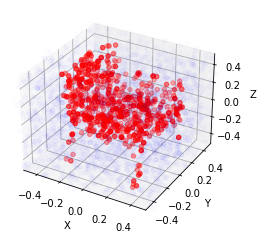

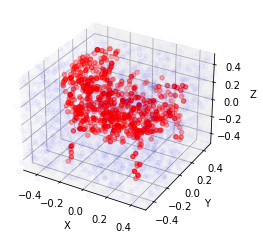

In [10]:
for loader in [train_loader, val_loader]:
  check_points, check_occs = [], []
  
  for pts, occs in loader:
    check_points.extend(pts)
    check_occs.extend(occs)
    if len(check_points) >= 10000:      # only visualize some points
      break
  
  check_points, check_occs = torch.stack(check_points), torch.stack(check_occs)
  visualize_occupancy(check_points, check_occs)

Does this look correct? If it does, it is time to define our classifier. We will implement this as a PyTorch module that we call *OccNet*. Complete the following class such that we obtain a network with **4 hidden layers of hidden dimension 64** (6 layers in total, 4 hidden + 1 input + 1 output). 
The model takes a batch of 3D points as input and should predict a single occupancy value for each point.
Use the PyTorch class `nn.Linear` for the linear layers and `nn.ReLU` as activation function.

*Hint 2*: ˙*ɹǝʎɐl ʇndʇno ǝɥʇ ɹoɟ ʇdǝɔxǝ* ɹǝʎɐl ɹɐǝuᴉl ʎɹǝʌǝ ɹǝʇɟɐ pǝpǝǝu sᴉ uoᴉʇɔunɟ uoᴉʇɐʌᴉʇɔɐ ǝɥ┴

In [22]:
###########################
#### Exercise Function ####
###########################
class OccNet(nn.Module):
  """ Network to predict an occupancy value for every 3D location. 
  
  Args:
  size_h (int): hidden dimension
  n_hidden (int): number of hidden layers
  """
  def __init__(self, size_h=64, n_hidden=4):
    super().__init__()
    
    # Insert your code here
    size_in =3
    size_out = 1
    actvn = nn.ReLU()
    
    layers = []
    layers.extend(
      [nn.Linear(size_in,size_h),
      actvn,
    ])
    for _ in range(n_hidden):
      layers.extend(
        [nn.Linear(size_h,size_h),
          actvn,
      ])
        
    layers.append(nn.Linear(size_h,size_out))
    
    self.main = nn.Sequential(*layers)

  def forward(self, pts):
    return self.main(pts).squeeze(-1)       # squeeze dimension of the single output value

model = OccNet(size_h=64, n_hidden=4)

# put the model on the GPU to accelerate training
if torch.cuda.is_available():
  model = model.cuda()
else:
  print('Fall back to CPU - GPU usage is recommended, e.g. using Google Colab.')

Fall back to CPU - GPU usage is recommended, e.g. using Google Colab.


We train the classifier with binary cross entropy as objective and the Adam optimizer.

In [23]:
criterion = nn.BCEWithLogitsLoss(reduction='none')    # binary cross entropy loss + softmax
optimizer = torch.optim.Adam(model.parameters())

Now everything is set! Let us write the training loop for our model.

*Hint 3*: ˙[lɐᴉɹoʇnʇ ɥɔɹo┴ʎԀ](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) sᴉɥʇ ɟo ɹnoɟ ʇuᴉod ʇɐ ʞool ɐ ǝʞɐʇ ǝldɯɐxǝ uɐ ɹoℲ


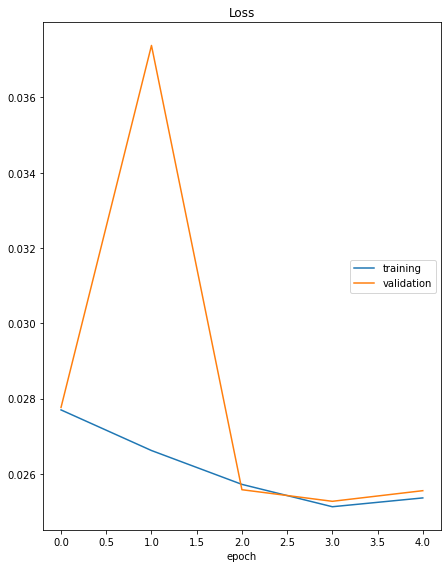

Loss
	training         	 (min:    0.025, max:    0.028, cur:    0.025)
	validation       	 (min:    0.025, max:    0.037, cur:    0.026)


In [27]:
###########################
#### Exercise Function ####
###########################
def train_model(model, train_loader, val_loader, optimizer, criterion, nepochs=15, eval_every=100, out_dir='output'):
  
  liveloss = PlotLosses()   # to plot training progress
  losses = {'loss': None,
            'val_loss': None}

  best = float('inf')
  it = 0
  for epoch in range(nepochs):

    losses['loss'] = []       # initialize emtpy container for training losses
    for pts, occ in train_loader:
      it += 1

      # Insert your code here
      optimizer.zero_grad()
      score = model(pts)
      loss = criterion(score,occ).mean()
      loss.backward()
      optimizer.step()
      
      losses['loss'].append(loss.item())

      if (it == 1) or (it % eval_every == 0):
        
        with torch.no_grad():
          val_loss = []
          for val_pts, val_occ in val_loader:
            
            # Insert your code here
            val_score=model(val_pts)
            val_loss_i = criterion(val_score,val_occ)
            val_loss.extend(val_loss_i)
              
          val_loss = torch.stack(val_loss).mean().item()
          
          if val_loss < best:     # keep track of best model
            best = val_loss
            torch.save(model.state_dict(), os.path.join(out_dir, 'model_best.pt'))

    # update liveplot with latest values
    losses['val_loss'] = val_loss
    losses['loss'] = np.mean(losses['loss'])     # average over all training losses
    liveloss.update(losses)
    liveloss.send()

train_model(model, train_loader, val_loader, optimizer, criterion, nepochs=5, eval_every=100, out_dir=out_dir)


Do training and validation loss curves look good? Or do you see any under / overfitting?

Great! We have now a trained occupancy network that encodes our 3D shape.

## Extracting the Object from the Implicit Representation

Let us now try to get back the 3D shape using only the trained network. To this end, we define the following helper function to obtain a grid of equidistant 3D sampling points.

In [28]:
###########################
#### Helper Function ######
###########################
def make_grid(xmin, xmax, resolution):
  """ Create equidistant points on 3D grid (cube shaped).
  
  Args:
  xmin (float): minimum for x,y,z
  xmax (float): number of hidden layers
  """
  grid_1d = torch.linspace(xmin, xmax, resolution)
  grid_3d = torch.stack(torch.meshgrid(grid_1d, grid_1d, grid_1d), -1)
  return grid_3d.flatten(0, 2)     # return as flattened tensor: RxRxRx3 -> (R^3)x3

resolution = 128          # use 128 grid points in each of the three dimensions -> 128^3 query points
grid = make_grid(-0.5, 0.5, resolution)

# wrap query points in data loader
batch_size = 128
test_loader = torch.utils.data.DataLoader(
    grid, batch_size=128, num_workers=1, shuffle=False, drop_last=False
)


Evaluate the best model on all of the grid points.

In [30]:
from tqdm import tqdm

###########################
#### Exercise Function ####
###########################
weights_best = torch.load(os.path.join(out_dir, 'model_best.pt'))     # we saved the best model there in the training loop
model.load_state_dict(weights_best)
grid_values = []
with torch.no_grad():
  for pts in tqdm(test_loader,desc='Evaluate occupancy of grid points', position=0, leave=True):
    grid_values.extend(model(pts))
grid_values = torch.stack(grid_values)      

# Insert your code here

Evaluate occupancy of grid points: 100%|██████████| 16384/16384 [00:24<00:00, 668.57it/s]


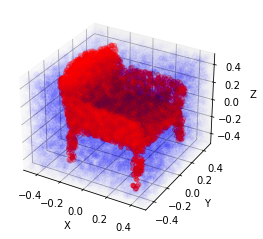

In [31]:
grid_occupancies = grid_values > 0.       # convert model scores to classification score
visualize_occupancy(grid, grid_occupancies)

Does it look as expected? If it does, let's finish off this exercise by extract the mesh using the *Marching Cubes* algorithm.

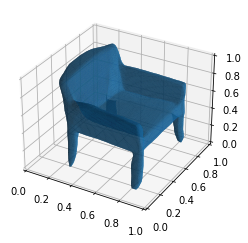

In [32]:
# extract mesh with Marching Cubes
threshold = 0. # because grid values are model scores
assert (grid_values.min() <= threshold) and (grid_values.max() >= threshold), "Threshold is not in range of predicted values"

vertices, faces, _, _ = marching_cubes(grid_values.reshape(resolution, resolution, resolution).numpy(), 
                                                  threshold, 
                                                  spacing=(1/(resolution-1), 1/(resolution-1), 1/(resolution-1)),
                                                  allow_degenerate=False)

# plot mesh
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(vertices[:, 0], vertices[:,1], triangles=faces, Z=vertices[:,2])

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

plt.show()

Great job! You now gained hands-on experience with representations of 3D shapes! 
